Training set: Cats: 72, Non-Cats: 137
Test set: Cats: 33, Non-Cats: 17
Cost after iteration 0: 0.7204659190943278
Cost after iteration 100: 0.6556489662897466
Cost after iteration 200: 0.6388759561750963
Cost after iteration 300: 0.6276627513260197
Cost after iteration 400: 0.6136859033411585
Cost after iteration 500: 0.5949232333272753
Cost after iteration 600: 0.5709787476140049
Cost after iteration 700: 0.560622992258504
Cost after iteration 800: 0.54473142458943
Cost after iteration 900: 0.5183170605901045
Cost after iteration 1000: 0.49688319367746925
Cost after iteration 1100: 0.47842995577337843
Cost after iteration 1200: 0.4655548428782716
Cost after iteration 1300: 0.4444636913731818
Cost after iteration 1400: 0.4330575388467847
Cost after iteration 1500: 0.41379425567085576
Cost after iteration 1600: 0.39911200193213553
Cost after iteration 1700: 0.4180808866816955
Cost after iteration 1800: 0.37997559096016653
Cost after iteration 1900: 0.3421517694296869
Cost after iteratio

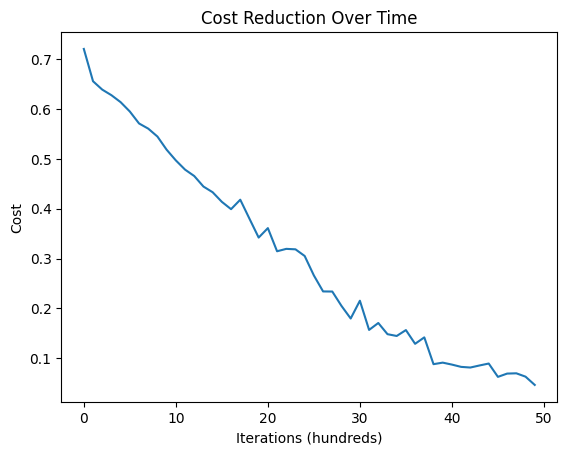

Train accuracy: 100.00%
Test accuracy: 74.00%
Prediction for test image 0: Cat


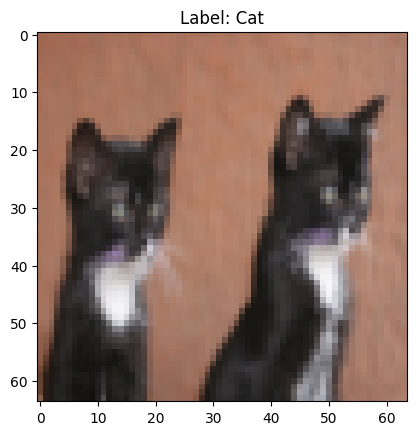

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split

# Load and preprocess dataset
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])  # Shape: (m, 64, 64, 3)
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  # Shape: (m,)
    
    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])  # Shape: (m_test, 64, 64, 3)
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  # Shape: (m_test,)
    
    # Flatten and normalize images
    train_set_x = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T / 255.  # Shape: (12288, m)
    test_set_x = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T / 255.  # Shape: (12288, m_test)
    train_set_y = train_set_y_orig.reshape(1, -1)  # Shape: (1, m)
    test_set_y = test_set_y_orig.reshape(1, -1)  # Shape: (1, m_test)
    
    return train_set_x, train_set_y, test_set_x, test_set_y, train_set_x_orig

train_x, train_y, test_x, test_y, train_set_x_orig = load_dataset()

# Check dataset balance
train_cat_count = np.sum(train_y == 1)
train_noncat_count = np.sum(train_y == 0)
test_cat_count = np.sum(test_y == 1)
test_noncat_count = np.sum(test_y == 0)

print(f"Training set: Cats: {train_cat_count}, Non-Cats: {train_noncat_count}")
print(f"Test set: Cats: {test_cat_count}, Non-Cats: {test_noncat_count}")

# Simple data augmentation: horizontal flip and rotation
def augment_data(X_orig, Y):
    m = X_orig.shape[0]
    # Horizontal flip
    flipped = X_orig[:, :, ::-1, :]  # Flip width dimension
    # Simple rotation (90 degrees)
    rotated = np.rot90(X_orig, k=1, axes=(1, 2))  # Rotate 90 degrees
    # Combine original, flipped, and rotated
    X_aug = np.concatenate((X_orig, flipped, rotated), axis=0)
    Y_aug = np.concatenate((Y, Y, Y), axis=1)  # Duplicate labels
    # Flatten and normalize
    X_aug_flat = X_aug.reshape(X_aug.shape[0], -1).T / 255.
    return X_aug_flat, Y_aug

train_x_aug, train_y_aug = augment_data(train_set_x_orig, train_y)

# Activation functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

# Initialize parameters with Xavier initialization
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L):
        # Xavier initialization for better gradient flow
        parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(1 / layer_dims[l-1])
        parameters[f'b{l}'] = np.zeros((layer_dims[l], 1))
    return parameters

# Forward propagation with dropout
def forward_propagation_deep_with_dropout(X, parameters, keep_prob=0.7):
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1, L):
        A_prev = A
        Z = np.dot(parameters[f'W{l}'], A_prev) + parameters[f'b{l}']
        A = relu(Z)
        D = np.random.rand(A.shape[0], A.shape[1]) < keep_prob  # Dropout mask
        A = A * D / keep_prob  # Scale to maintain expected value
        caches.append((A_prev, Z, parameters[f'W{l}'], parameters[f'b{l}'], D))
    
    ZL = np.dot(parameters[f'W{L}'], A) + parameters[f'b{L}']
    AL = sigmoid(ZL)
    caches.append((A, ZL, parameters[f'W{L}'], parameters[f'b{L}'], None))
    return AL, caches

# Compute cost
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL)) / m
    cost = np.squeeze(cost)
    return cost

# Backward propagation with dropout
def backward_propagation_deep_with_dropout(X, Y, AL, caches, keep_prob=0.7):
    grads = {}
    L = len(caches)
    m = X.shape[1]
    
    dZL = AL - Y
    A_prev, ZL, WL, bL, _ = caches[L-1]
    grads[f'dW{L}'] = np.dot(dZL, A_prev.T) / m
    grads[f'db{L}'] = np.sum(dZL, axis=1, keepdims=True) / m
    
    for l in range(L-1, 0, -1):
        A_prev, Z, W, b, D = caches[l-1]
        dZ = np.dot(caches[l][2].T, dZL) * (Z > 0)  # ReLU derivative
        dZ = dZ * D / keep_prob  # Apply dropout mask
        grads[f'dW{l}'] = np.dot(dZ, A_prev.T) / m
        grads[f'db{l}'] = np.sum(dZ, axis=1, keepdims=True) / m
        dZL = dZ
    
    return grads

# Update parameters
def update_parameters_deep(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(1, L + 1):
        parameters[f'W{l}'] = parameters[f'W{l}'] - learning_rate * grads[f'dW{l}']
        parameters[f'b{l}'] = parameters[f'b{l}'] - learning_rate * grads[f'db{l}']
    return parameters

# Train the DNN with dropout
def train_dnn_with_dropout(X, Y, layer_dims, learning_rate=0.005, num_iterations=5000, keep_prob=0.7, print_cost=True):
    parameters = initialize_parameters_deep(layer_dims)
    costs = []
    
    for i in range(num_iterations):
        AL, caches = forward_propagation_deep_with_dropout(X, parameters, keep_prob)
        cost = compute_cost(AL, Y)
        grads = backward_propagation_deep_with_dropout(X, Y, AL, caches, keep_prob)
        parameters = update_parameters_deep(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0:
            print(f"Cost after iteration {i}: {cost}")
            costs.append(cost)
    
    return parameters, costs

# Predict function
def predict(X, parameters):
    AL, _ = forward_propagation_deep_with_dropout(X, parameters, keep_prob=1.0)  # No dropout during prediction
    predictions = (AL > 0.5).astype(int)
    return predictions

# Calculate accuracy
def accuracy(predictions, Y):
    return np.mean(predictions == Y) * 100

# Define layer dimensions
layer_dims = [12288, 64, 32, 16, 1]

# Train the model
parameters, costs = train_dnn_with_dropout(train_x_aug, train_y_aug, layer_dims, learning_rate=0.005, num_iterations=5000, keep_prob=0.7)

# Plot cost
plt.plot(costs)
plt.xlabel('Iterations (hundreds)')
plt.ylabel('Cost')
plt.title('Cost Reduction Over Time')
plt.show()

# Evaluate on train and test sets
train_pred = predict(train_x, parameters)
test_pred = predict(test_x, parameters)

print(f"Train accuracy: {accuracy(train_pred, train_y):.2f}%")
print(f"Test accuracy: {accuracy(test_pred, test_y):.2f}%")

# Example: Predict on a single image
index = 0
single_image = test_x[:, index].reshape(-1, 1)
prediction = predict(single_image, parameters)
print(f"Prediction for test image {index}: {'Cat' if prediction[0, 0] == 1 else 'Non-Cat'}")
plt.imshow(test_x[:, index].reshape(64, 64, 3))
plt.title(f"Label: {'Cat' if test_y[0, index] == 1 else 'Non-Cat'}")
plt.show()
